# Empirically determine ratio of nucleus to cytosol diameter

In [1]:
from pathlib import Path
from typing import List
import zarr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.measure import regionprops, label
import seaborn as sns
import time
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed


In [2]:
result_folder = Path("../snakemake/results/aggregated/broad/")

In [3]:
def find_zarr_files(directory: Path) -> List[Path]:
    """
    Recursively finds all .zarr files in the specified directory.

    Args:
        directory (Path): Path object pointing to the directory where .zarr files are searched.

    Returns:
        List[Path]: List of Path objects pointing to .zarr files found in the directory and its subdirectories.

    Raises:
        ValueError: If the provided path is not a valid directory.
    """
    if not directory.is_dir():
        raise ValueError(f"The provided path '{directory}' is not a valid directory.")
    return list(directory.rglob("*.zarr"))

def process_file(file_path: Path) -> int:
    """
    Process a single .zarr file to count cells across all its groups.

    Args:
        file_path (Path): Path to the .zarr file.

    Returns:
        int: Total number of cells in the file.

    Raises:
        OSError: If there is an error processing the file.
    """
    try:
        with zarr.open(file_path, mode="r") as file:
            return sum(count_cells(v) for k, v in file.items() if "single_cell_data" in v)
    except OSError as e:
        print(f"Error processing file {file_path}: {e}")
        return 0

def count_cells(image_group: zarr.hierarchy.Group) -> int:
    return image_group["single_cell_data"].shape[0]

def count_total_cells(file_paths: List[Path]) -> int:
    """
    Counts the total number of cells across multiple .zarr files in parallel.

    Args:
        file_paths (List[Path]): List of Path objects pointing to .zarr files.

    Returns:
        int: Total number of cells across all provided .zarr files.
    """
    total_cells = 0
    with ProcessPoolExecutor() as executor:
        future_to_file = {executor.submit(process_file, fp): fp for fp in file_paths}
        with tqdm(total=len(file_paths), desc="Counting cells", unit="file") as pbar:
            for future in as_completed(future_to_file):
                cells = future.result()
                total_cells += cells
                pbar.update(1)
                pbar.set_postfix(total_cells=total_cells, refresh=True)
    return total_cells

def calculate_diameters(file_path: Path) -> pd.DataFrame:
    """
    Calculates the diameters of the nucleus and cytosol for all cells in a .zarr file.

    Args:
        file_path (Path): Path to the .zarr file.

    Returns:
        pd.DataFrame: DataFrame with the diameters of the nucleus and cytosol for each cell.
    """
    results = []
    with zarr.open(file_path, mode="r") as file:
        for k, v in file.items():
            if "single_cell_data" in v:
                dataset = v["single_cell_data"]
                for cell_index in range(dataset.shape[0]):
                    nucleus_image = dataset[cell_index, 0, :, :]
                    cytosol_image = dataset[cell_index, 1, :, :]
                    nucleus_diameter = calculate_equivalent_diameter(nucleus_image)
                    cytosol_diameter = calculate_equivalent_diameter(cytosol_image)
                    results.append({
                        "cell_index": f"{file_path}_{cell_index}",
                        "cytosol": cytosol_diameter,
                        "nucleus": nucleus_diameter
                    })
            else:
                print(f"Dataset 'single_cell_data' not found in file: {file_path}")
    return pd.DataFrame(results)

def calculate_equivalent_diameter(binary_image: np.array) -> float:
    """
    Calculate the equivalent diameter of the largest connected component in a binary image.

    Args:
        binary_image (np.array): Binary image array.

    Returns:
        float: Equivalent diameter of the largest connected component.
    """
    labeled_image = label(binary_image)
    if regions := regionprops(labeled_image):
        largest_region = max(regions, key=lambda r: r.area)
        return largest_region.equivalent_diameter
    return 0


def calculate_all_diameters(file_paths: List[Path]) -> pd.DataFrame:
    """
    Calculates the diameters of the nucleus and cytosol for all cells in multiple .zarr files.

    Args:
        file_paths (List[Path]): List of Path objects pointing to .zarr files.

    Returns:
        pd.DataFrame: DataFrame with the diameters of the nucleus and cytosol for each cell.
    """
    results = []
    with ProcessPoolExecutor() as executor:
        future_to_file = {executor.submit(calculate_diameters, fp): fp for fp in file_paths}
        with tqdm(total=len(file_paths), desc="Calculating diameters", unit="file") as pbar:
            for future in as_completed(future_to_file):
                df = future.result()
                results.append(df)
                pbar.update(1)
    return pd.concat(results, ignore_index=True)

def add_stats_annotation(ax, data, x_position, color):
    """Helper function to add statistics annotations on the plot."""
    mean = np.mean(data)
    std = np.std(data)
    textstr = f"Mean: {mean:.2f}\n" + \
              f"1σ: [{mean-std:.2f}, {mean+std:.2f}]\n" + \
              f"2σ: [{mean-2*std:.2f}, {mean+2*std:.2f}]\n" + \
              f"3σ: [{mean-3*std:.2f}, {mean+3*std:.2f}]"
    
    # Position the text relative to the violin plot
    props = dict(boxstyle="round", facecolor=color, alpha=0.5)
    ax.text(x_position, max(data)+10, textstr, fontsize=10, horizontalalignment="center", bbox=props)


## Count cells

In [4]:
zarr_files = find_zarr_files(result_folder)
print(f"Found {count_total_cells(zarr_files)} cells in {len(zarr_files)} files.")

Counting cells: 100%|██████████| 99/99 [00:01<00:00, 69.97file/s, total_cells=446854] 


Found 446854 cells in 99 files.


## Preview of a single cell's segmentation results

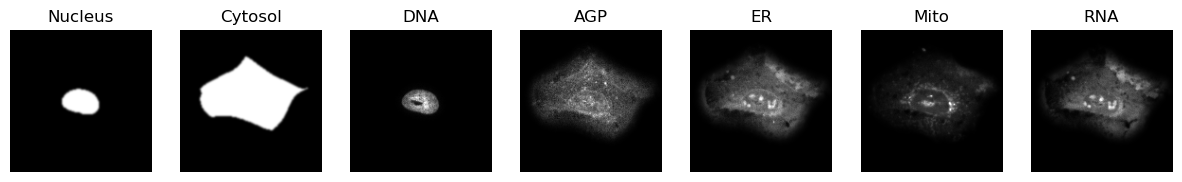

In [5]:
titles = ["Nucleus", "Cytosol", "DNA", "AGP", "ER", "Mito", "RNA"]

with zarr.open(zarr_files[0], mode="r") as file:

    plt.figure(figsize=(15, 3))

    for channel_index in range(7):
        image = list(file.items())[0][1]["single_cell_data"][0, channel_index, :, :]
        plt.subplot(1, 7, channel_index + 1)  # 1 row, 7 columns, subplot index
        plt.imshow(image, cmap="gray")
        plt.title(titles[channel_index])
        plt.axis('off') 

    plt.show()

## Determine average diameter for nucleus and cytosol

In [6]:
%%time

measurements = calculate_all_diameters(zarr_files)

Calculating diameters:   0%|          | 0/99 [00:00<?, ?file/s]

Calculating diameters: 100%|██████████| 99/99 [08:29<00:00,  5.15s/file] 

CPU times: user 327 ms, sys: 428 ms, total: 755 ms
Wall time: 8min 29s


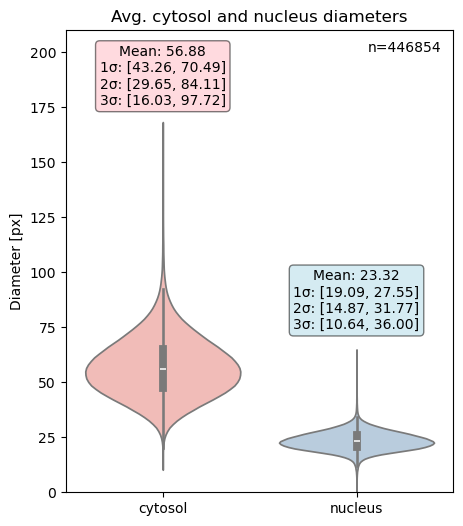

<Figure size 640x480 with 0 Axes>

In [7]:
plt.figure(figsize=(5, 6))
ax = sns.violinplot(data=measurements[["cytosol", "nucleus"]], palette="Pastel1")

add_stats_annotation(ax, measurements["cytosol"], 0, "lightpink")
add_stats_annotation(ax, measurements["nucleus"], 1, "lightblue")

plt.ylim(0, 210)
ax.text(1.25, 200, f"n={len(measurements)}", fontsize=10, horizontalalignment="center")
plt.title("Avg. cytosol and nucleus diameters")
plt.ylabel("Diameter [px]")
plt.show()
plt.savefig("./avg_diameter.png")